# Importing dependancies

In [19]:
import gym

import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model definition

We can use the state variables (position of cart, angle of pole)

In [21]:
class DQN(nn.Module):

    def __init__(self, output_size):
        super(DQN, self).__init__()
        self.fn1 = nn.LazyLinear(64)
        self.fn2 = nn.LazyLinear(64)
        self.fn3 = nn.LazyLinear(output_size)
        self.act = nn.PReLU()

    def forward(self, input):
        x = self.act(self.fn1(input))
        x = self.act(self.fn2(x))
        output = self.fn3(x)
        return output


# Memory
The agent should memorize what it learned before so it can learn from it

In [22]:
Experience = namedtuple('Experience', ('curr_state', 'action', 'next_state', 'reward', 'is_going'))

class Memory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def remember(self, *args):
        self.memory.append(Experience(*args))

    def recall(self, batch_size):
        experiences = random.sample(self.memory, batch_size)
        batch = Experience(*zip(*experiences))
        return batch

    def __len__(self):
        return len(self.memory)

# Creating the agent

In [23]:
class DDQNAgent:
    def __init__(self, env):
        env.reset()
        self.action_size = env.action_space.n # output size
        
        self.policy_model = DQN(self.action_size).to(device)
        self.target_model = DQN(self.action_size).to(device)
        self.target_model.load_state_dict(self.policy_model.state_dict())

        self.loss_fn = nn.SmoothL1Loss()
        self.optimizer = optim.Adam(self.policy_model.parameters(), lr=0.0005)

        self.exploration_rate = 1 # initial exploration rate, always leave at 1
        self.exploration_rate_decay = 0.9999 # rate at which the exploration decreases
        self.exploration_rate_min = 0.1 # minimun exploration rate
        
        self.gamma = 0.995 # falloff for Q score

        self.batch_size = 64
        self.num_epochs = 500
        self.img_size = 100
        self.update_rate = 5

        self.memory = Memory(10000) # how many of the previous samples are used
    
    def act(self, state):
        if random.random() < self.exploration_rate:
            action = random.randrange(self.action_size) # act randomly
        else:
            action = self.act_ideal(state) # act ideally
            
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        
        return action
    
    def act_ideal(self, state):
        return self.policy_model(state).max(1)[1].item()
    
    def train_step(self):
        if len(self.memory) < self.batch_size:
            return
        batch = self.memory.recall(self.batch_size)
        
        curr_states = torch.stack(batch.curr_state).squeeze(1)
        actions = torch.Tensor(np.array(batch.action)).to(device)
        next_states = torch.stack(batch.next_state).squeeze(1)
        rewards = torch.Tensor(np.array(batch.reward)).to(device)
        is_goings = torch.Tensor(np.array(batch.is_going)).to(device)
        
        # This is the fundamental logic behind calulating a deep Q value.
        curr_Q = self.policy_model(curr_states).mul(actions).sum(1)
        next_Q = self.target_model(next_states).max(1)[0]
        expected_Q = rewards + is_goings * self.gamma * next_Q

        loss = self.loss_fn(expected_Q, curr_Q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def train(self, env, print_epochs=False, render=False):

        scores = []

        for epoch in range(self.num_epochs):
            done = False
            curr_state = env.reset()
            curr_state = torch.Tensor(curr_state).to(device)
            score = 0
            
            while not done:
                if render:
                    env.render()

                action = self.act(curr_state.unsqueeze(0))
                next_state, reward, done, _ = env.step(action)
                next_state = torch.Tensor(next_state).to(device)
                action_encode = np.eye(self.action_size)[action]
                self.memory.remember(curr_state, action_encode, next_state, reward, 1 - done)

                curr_state = next_state

                score += reward
                      
                self.train_step()

            if epoch % self.update_rate == 0:
                self.target_model.load_state_dict(self.policy_model.state_dict())

            scores.append(score)
            if print_epochs:
                print("Epoch: " + str(epoch + 1) + ". Score is: " + str(score))

            
        return scores

    def test(self, env, num_trials=100, render=False):
        test_scores = []

        for i in range(num_trials):

            done = False
            curr_state = env.reset()
            curr_state = torch.Tensor(curr_state).to(device)
            score = 0

            while not done:
                if score < curr_state[0].item():
                    score = curr_state[0].item()

                if render:
                    env.render()

                action = self.act_ideal(curr_state.unsqueeze(0))
                curr_state, _, done, _ = env.step(action)
                curr_state = torch.Tensor(curr_state).to(device)
            
            test_scores.append(score)
            
        return sum(test_scores) / num_trials
                

# Training the agent

Epoch: 1. Score is: -200.0
Epoch: 2. Score is: -200.0
Epoch: 3. Score is: -200.0
Epoch: 4. Score is: -200.0
Epoch: 5. Score is: -200.0
Epoch: 6. Score is: -200.0
Epoch: 7. Score is: -200.0
Epoch: 8. Score is: -200.0
Epoch: 9. Score is: -200.0
Epoch: 10. Score is: -200.0
Epoch: 11. Score is: -200.0
Epoch: 12. Score is: -200.0
Epoch: 13. Score is: -200.0
Epoch: 14. Score is: -200.0
Epoch: 15. Score is: -200.0
Epoch: 16. Score is: -200.0
Epoch: 17. Score is: -200.0
Epoch: 18. Score is: -200.0
Epoch: 19. Score is: -200.0
Epoch: 20. Score is: -200.0
Epoch: 21. Score is: -200.0
Epoch: 22. Score is: -200.0
Epoch: 23. Score is: -200.0
Epoch: 24. Score is: -200.0
Epoch: 25. Score is: -200.0
Epoch: 26. Score is: -200.0
Epoch: 27. Score is: -200.0
Epoch: 28. Score is: -200.0
Epoch: 29. Score is: -200.0
Epoch: 30. Score is: -200.0
Epoch: 31. Score is: -200.0
Epoch: 32. Score is: -200.0
Epoch: 33. Score is: -200.0
Epoch: 34. Score is: -200.0
Epoch: 35. Score is: -200.0
Epoch: 36. Score is: -200.0
E

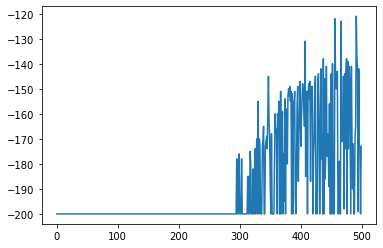

In [24]:
env = gym.make("MountainCar-v0")
agent = DDQNAgent(env)
env.reset()
scores = agent.train(env, print_epochs=True, render=False)
plt.plot(scores)
plt.show()

In [ ]:
np.save('mountaincar_dqn_scores', scores)